# Currency Weather Analysis & Prediction

This notebook analyzes the relationship between weather conditions in Iceland and USD/ISK exchange rate.

## Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn')
sns.set_palette("husl")

## Load Data from Database

In [2]:
from src.database.connection import get_merged_data

# Get merged data
df = get_merged_data()
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 31 rows of data


,date,rate,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,weather_code
0,2024-10-17,136.460007,0.1,0.2,20.3,71
1,2024-10-18,136.460007,1.6,10.4,47.7,75
2,2024-10-19,136.460007,1.6,10.8,58.3,75
3,2024-10-20,136.460007,0.4,2.3,21.9,73
4,2024-10-21,136.460007,-2.2,12.0,14.8,75


## Data Exploration

In [3]:
# Basic information about the dataset
print("Dataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 31 non-null     object 
 1   rate                 31 non-null     float64
 2   temperature_2m_mean  31 non-null     float64
 3   precipitation_sum    31 non-null     float64
 4   wind_speed_10m_max   31 non-null     float64
 5   weather_code         31 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.6+ KB

Missing Values:
date                   0
rate                   0
temperature_2m_mean    0
precipitation_sum      0
wind_speed_10m_max     0
weather_code           0
dtype: int64

Basic Statistics:


,rate,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,weather_code
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,137.151618,-0.477419,6.335484,44.964516,64.483871
std,0.680719,4.540243,4.934879,19.011918,21.316458
min,136.460007,-9.100000,0.000000,14.800000,3.000000
25%,136.460007,-3.200000,2.300000,28.050000,71.000000
50%,137.800003,0.100000,6.400000,46.400000,73.000000
75%,137.800003,3.650000,10.800000,58.050000,75.000000
max,137.800003,6.800000,17.100000,88.300000,75.000000


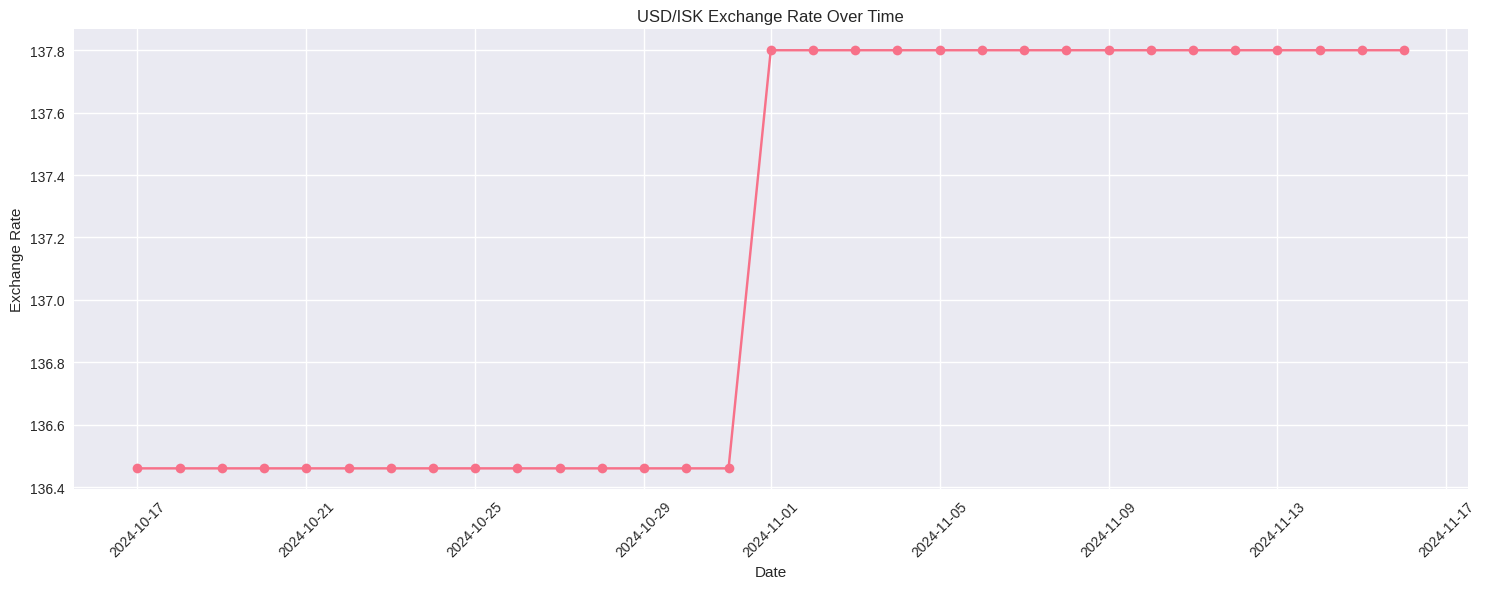

In [4]:
# Time series plot of exchange rate
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['rate'], marker='o')
plt.title('USD/ISK Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

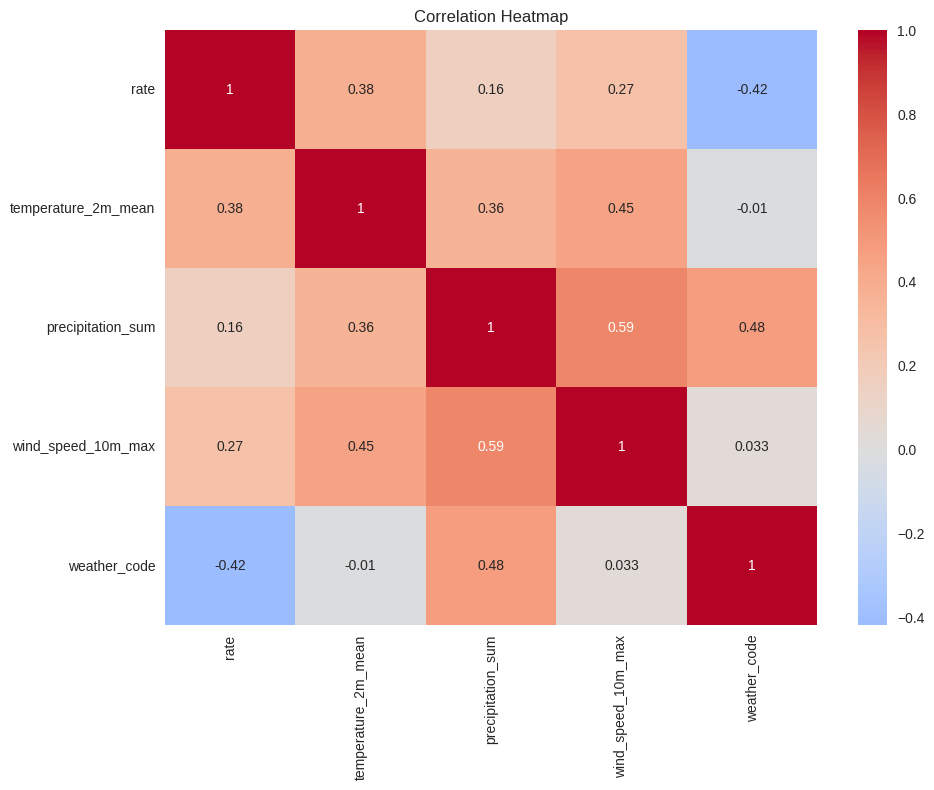

In [5]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = df.drop('date', axis=1).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

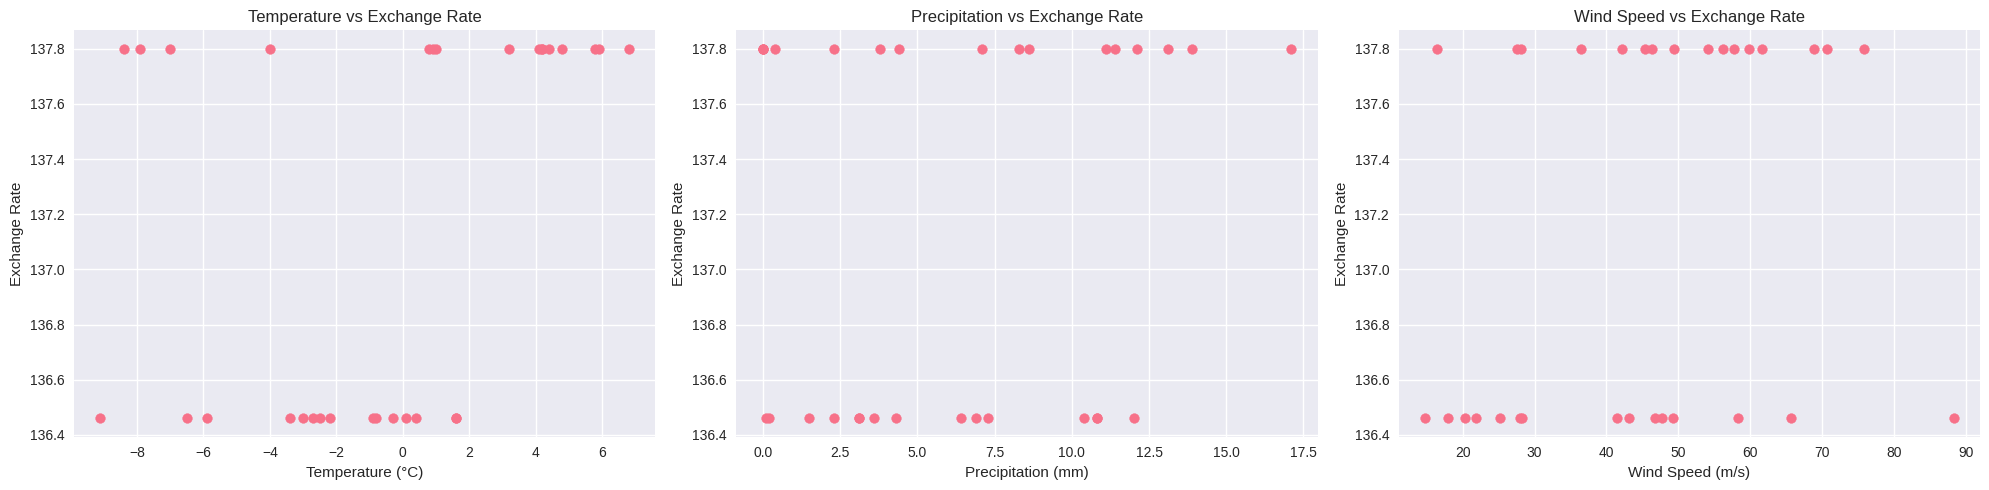

In [6]:
# Scatter plots with weather variables
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Temperature vs Rate
axes[0].scatter(df['temperature_2m_mean'], df['rate'])
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Exchange Rate')
axes[0].set_title('Temperature vs Exchange Rate')

# Precipitation vs Rate
axes[1].scatter(df['precipitation_sum'], df['rate'])
axes[1].set_xlabel('Precipitation (mm)')
axes[1].set_ylabel('Exchange Rate')
axes[1].set_title('Precipitation vs Exchange Rate')

# Wind Speed vs Rate
axes[2].scatter(df['wind_speed_10m_max'], df['rate'])
axes[2].set_xlabel('Wind Speed (m/s)')
axes[2].set_ylabel('Exchange Rate')
axes[2].set_title('Wind Speed vs Exchange Rate')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [7]:
def remove_outliers(df, columns):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & 
            (df_clean[column] <= upper_bound)
        ]
    
    return df_clean

# Remove outliers
numeric_columns = [
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'rate'
]

df_clean = remove_outliers(df, numeric_columns)
print(f"Rows after outlier removal: {len(df_clean)} (removed {len(df) - len(df_clean)} rows)")

Rows after outlier removal: 31 (removed 0 rows)


In [8]:
# Prepare features and target
X = df_clean.drop(['date', 'rate'], axis=1)
y = df_clean['rate']

# Split data chronologically
train_size = int(0.8 * len(df_clean))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 24
Test set size: 7


## Model Training and Evaluation


Linear Regression Results:
RMSE: 0.9117
R2 Score: 0.0000


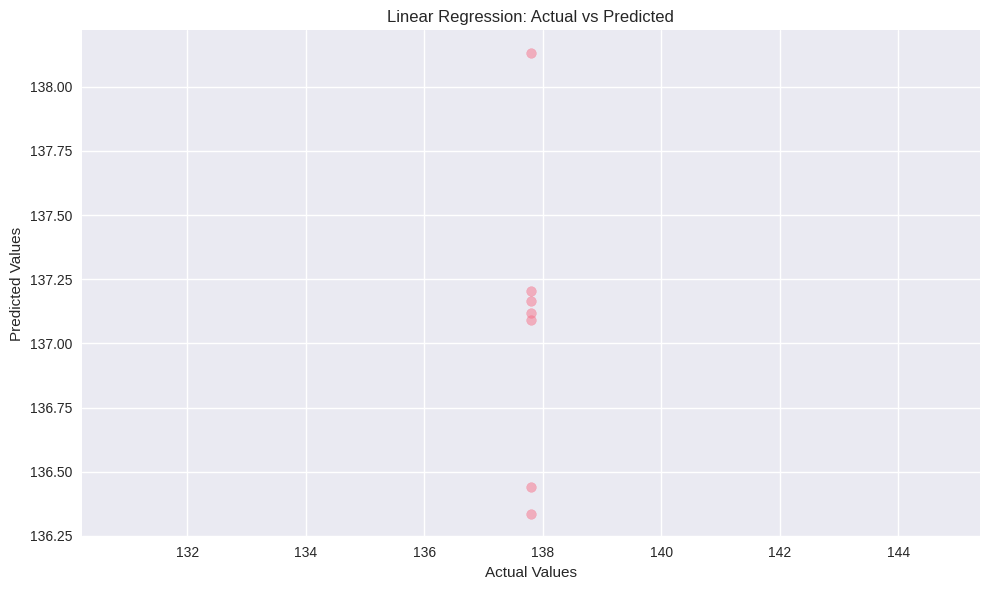


XGBoost Results:
RMSE: 1.0880
R2 Score: 0.0000


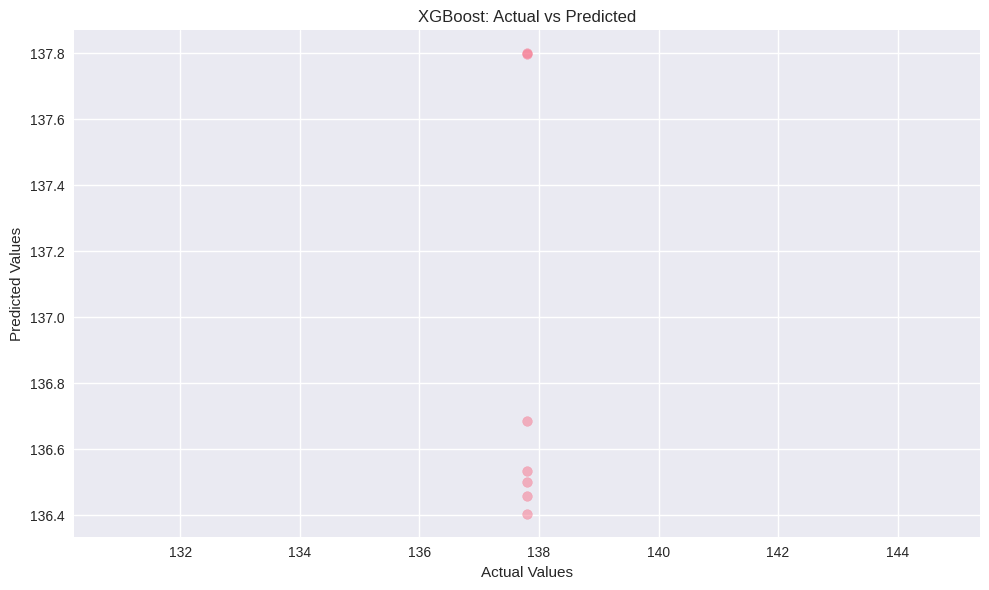


Random Forest Results:
RMSE: 0.8573
R2 Score: 0.0000


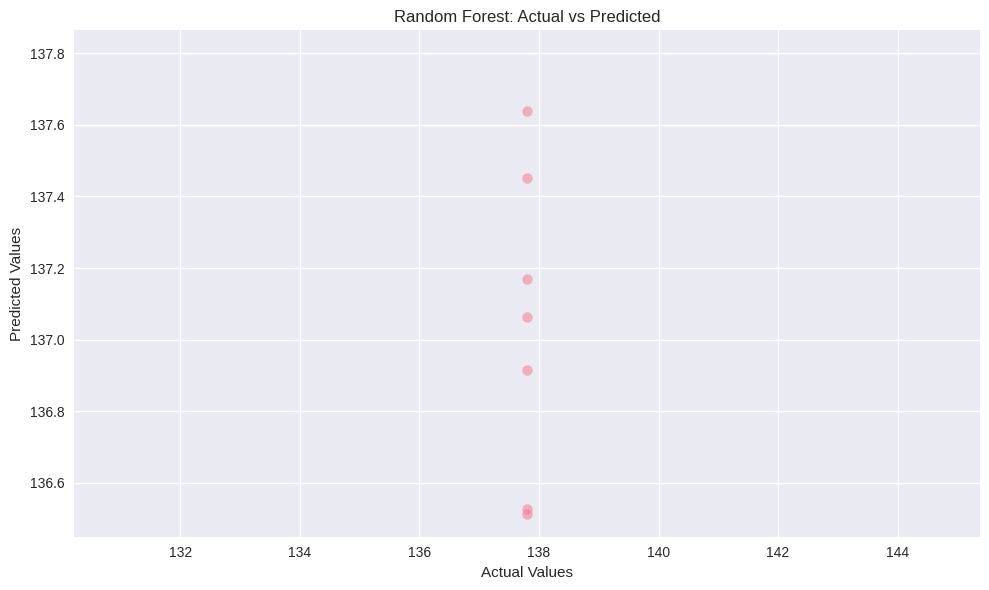


Decision Tree Results:
RMSE: 1.1325
R2 Score: 0.0000


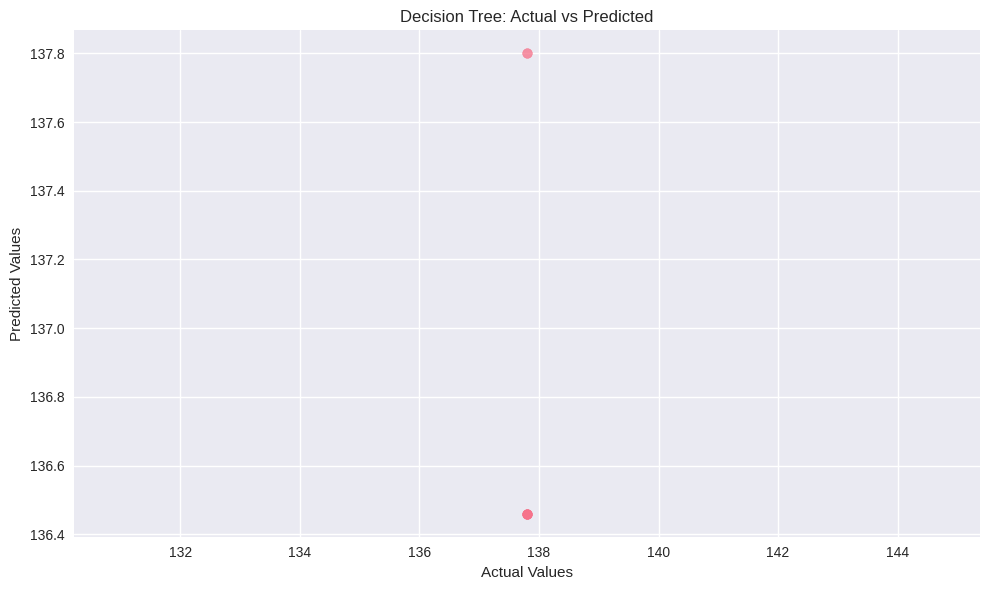

In [9]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model"""
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.tight_layout()
    plt.show()
    
    return model, rmse, r2, y_pred

# Train and evaluate different models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = train_and_evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name
    )

## Feature Importance Analysis

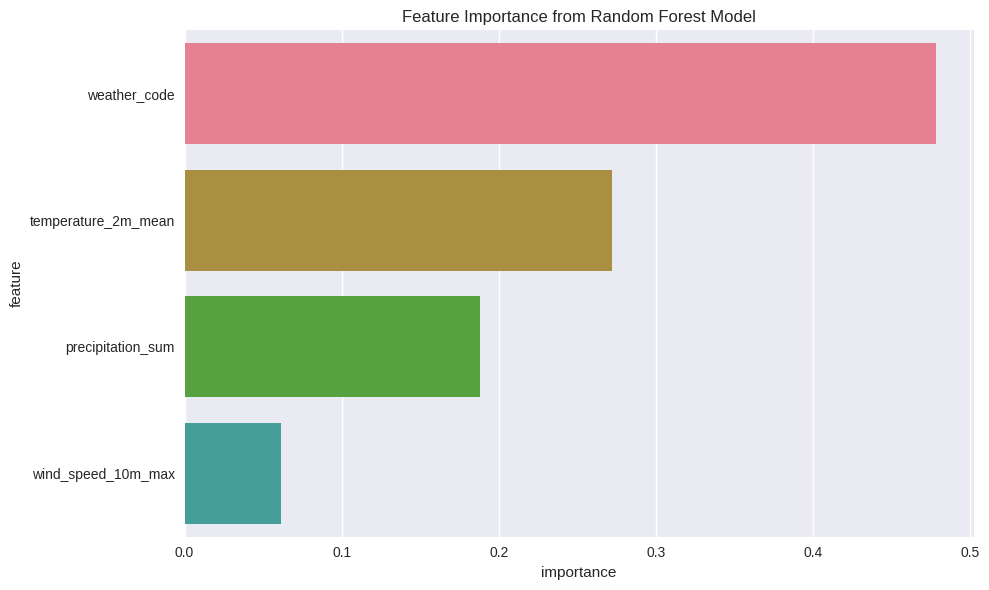

In [10]:
# Get feature importance from Random Forest model
rf_model = results['Random Forest'][0]
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

## Model Comparison

Model Performance Comparison:
            Model     RMSE  R2
Linear Regression 0.911688 0.0
          XGBoost 1.087950 0.0
    Random Forest 0.857284 0.0
    Decision Tree 1.132504 0.0


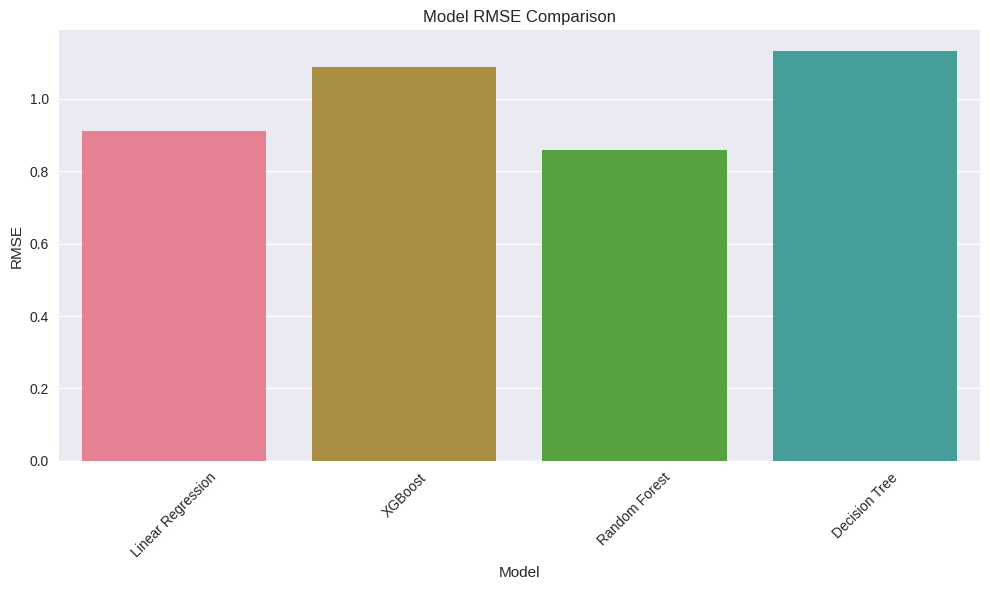

In [11]:
# Compare model performance
model_comparison = pd.DataFrame([
    {
        'Model': name,
        'RMSE': results[name][1],
        'R2': results[name][2]
    }
    for name in models.keys()
])

print("Model Performance Comparison:")
print(model_comparison.to_string(index=False))

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison, x='Model', y='RMSE')
plt.title('Model RMSE Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()